In [24]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import math
import time
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pmdarima import auto_arima

In [2]:
# Fetching data
df = pd.read_csv('../data/dataset.csv')

<AxesSubplot:xlabel='Time'>

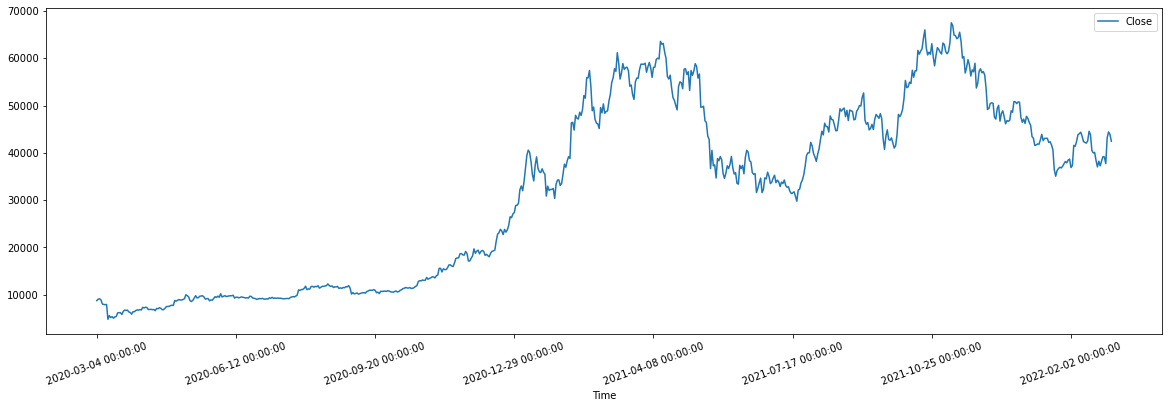

In [3]:
# Plotting btc prices
df.plot(x='Time', y='Close', kind='line', figsize=(20,6), rot=20)

In [4]:
#Testing for stationarity using ADF and KPSS Tests.

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='green', label = 'Rolling Std Dev')
    plt.plot(stock_close_price, color='red',label='Original Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags=None, store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -1.329072
p-value: 0.615769
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 2.722599
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


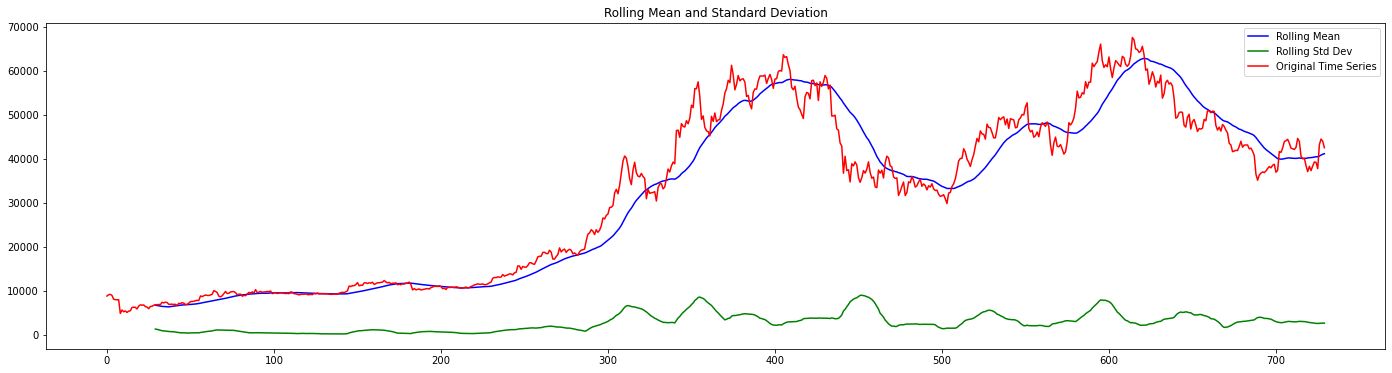

In [7]:
stationarity_test(df['Close'])

In [11]:
#Testing for stationarity of de-trended time series using ADF and KPSS Tests.

# De-trending the time series
df['Close_Detrend'] = (df['Close'] - df['Close'].shift(5))

In [15]:
def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(5).mean()
    rolling_std_dev = stock_close_price.rolling(5).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(stock_close_price,label='De-Trended Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags=None, store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -4.845736
p-value: 0.000044
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.130288
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


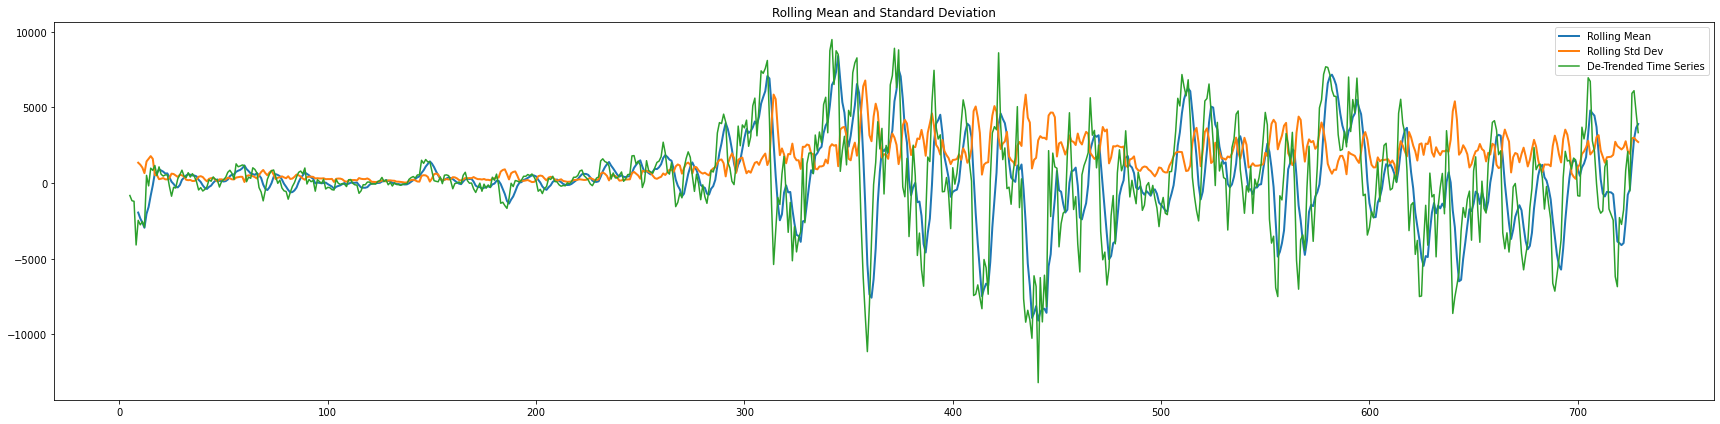

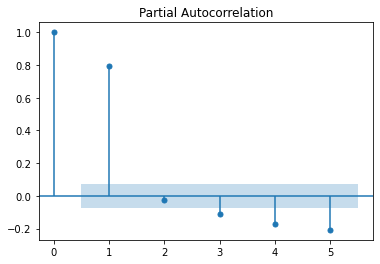

In [16]:
stationarity_test(df['Close_Detrend'].dropna())

# PACF Plot
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['Close_Detrend'].dropna(), lags=5)

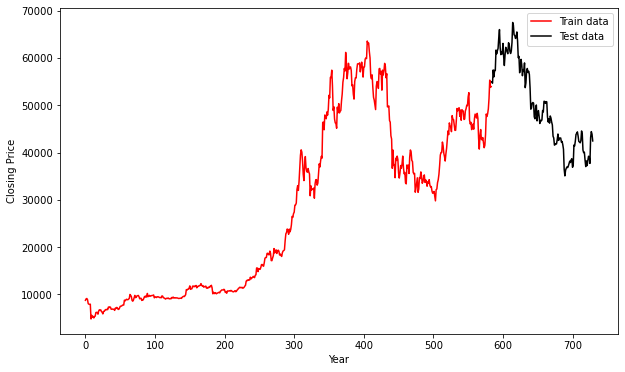

In [17]:
#split data into train and training set
data_arima = df['Close']
train_test_split_ratio = int(len(data_arima)*0.8)
train_data, test_data = data_arima[:train_test_split_ratio], data_arima[train_test_split_ratio:]


# Plotting the train and test sets.
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend()

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/sylvia/opt/anaconda3/lib/python3.9/site-pac

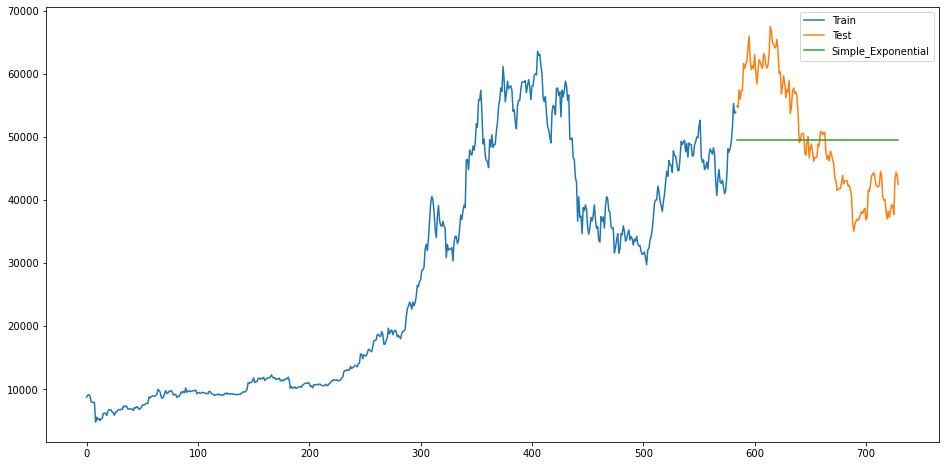

Simple Exponential Smoothing RMS :- 9138.826 & Smoothing Level :- 0.15


In [20]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

Simple_Exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
  fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
  pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

  rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
  Simple_Exponential_df = Simple_Exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = Simple_Exponential_df.loc[Simple_Exponential_df['RMS'] == min(Simple_Exponential_df['RMS']),['Smoothing Level']].values


# Using optimised values from the lists.
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarn

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/vd/gzksmjq50yj4mhf15m0b04sh0000gn/T/ipykernel_19243/2614779661.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
/Users/sylvia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py

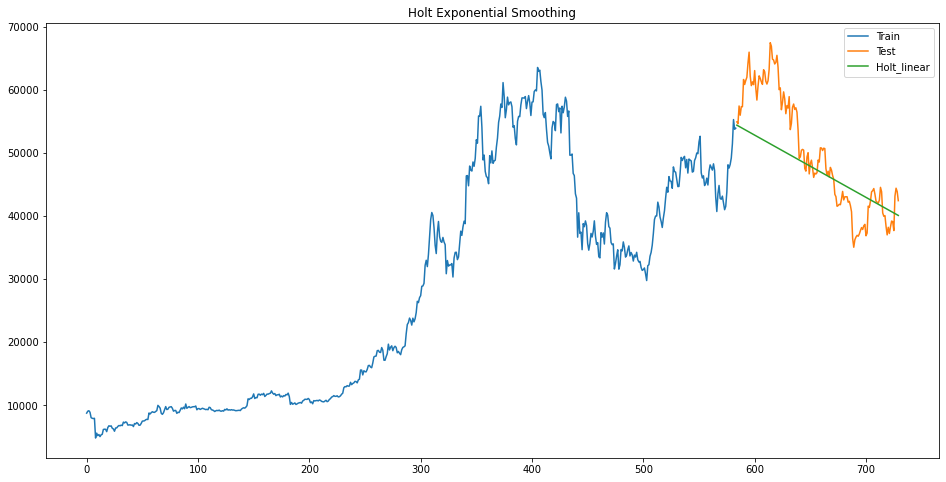

Holt’s Exponential Smoothing RMS :- 6240.315 & Smoothing Level :- 0.7 & Smoothing Slope :- 0.8


In [21]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
  pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

  rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
  holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10097.249, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10095.372, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10095.565, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10095.712, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10095.189, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.272 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5046.594
Date:                Wed, 20 Apr 2022   AIC                          10095.189
Time:                        23:06:23   BIC                          10099.557
Sample:                             0   HQIC                         10096.891
                                - 584                                  

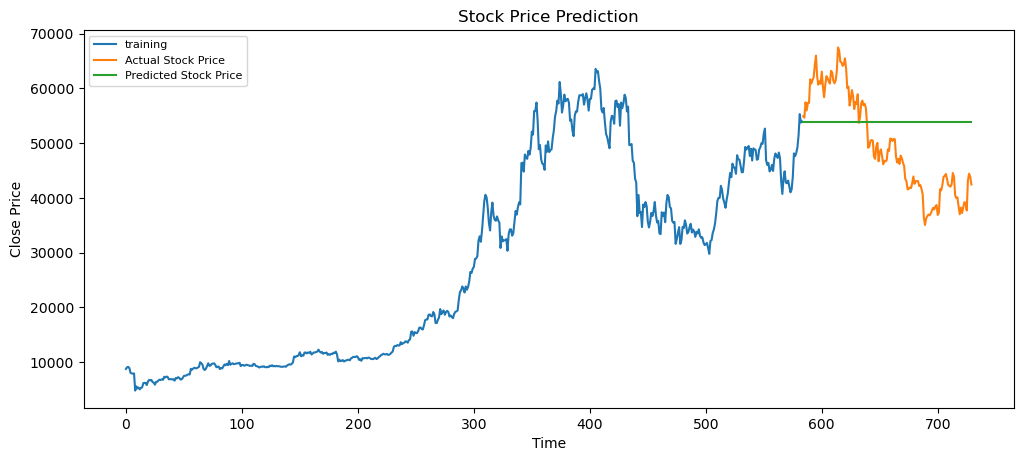

Auto-Arima RMSE :- 10007.115


In [25]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fitting the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting the values.
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

#Plotting the predicted stock price and original price.
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fcv_series,label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluating the model by calculating RMSE.
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))